<a href="https://colab.research.google.com/github/kskaran94/WasteClassification/blob/master/Waste_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries Imported

In [0]:
from google.colab import files
import json
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, \
Dense, Dropout, Input, add
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, save_model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, \
 recall_score, confusion_matrix, precision_recall_curve
from tensorflow.keras.models import save_model, load_model
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import os
import random
import time

## Download Data from Kaggle

In [2]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

token = {"username":"kskaran94","key":"e845a1f4ce47bb7f34dc6ec9f108f676"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
    
! chmod 600 /root/.kaggle/kaggle.json

! kaggle datasets download -d techsash/waste-classification-data

cp: cannot stat 'kaggle.json': No such file or directory
 96% 217M/225M [00:05<00:00, 43.3MB/s]
100% 225M/225M [00:05<00:00, 44.2MB/s]


In [0]:
!unzip waste-classification-data.zip

## Dataset File Structure

The first step after downloading the data would be to look at the data set file structure. 

In [0]:
!ls DATASET/

TEST  TRAIN


We, see that the dataset has pre-defined train and test splits. We are missing a validation and before any modling or configuration, the task would be to construct a validation set from the existing train test. At this point, test set is untouched.

In [0]:
!ls DATASET/TRAIN/

O  R


## Objective

Build a image classifier to correctly identify Recyclable and Organic waste.  This would help government authorities reduce toxic waste in landfills. Thereby reducing land pollution.

## Util Functions

All the custom functions used in the notebook can be found in this block.

### Copying files

Function copies given file_nams from source to destination using shutil

In [0]:
def copyfiles(file_names, dest, src_path):
    for file in file_names:
        full_file_name = os.path.join(src_path, file)
        if os.path.isfile(full_file_name):
            shutil.copy(full_file_name, dest)

### Train Validation Split

Function takes a path of a directory and percentage of train to split the data into train and validation. Sklearn's train_test_split works only with dataframes /arrays. This function is written for  directory-file structure.

In [0]:
def train_val_test_split(path, perc):
    train_string  = 'train/'
    val_string  = 'val/' 
    dest_path = '/content/'
    try:
        os.mkdir(dest_path + train_string)
        os.mkdir(dest_path + val_string)
    except:
        shutil.rmtree(dest_path + train_string)
        shutil.rmtree(dest_path + val_string)
        os.mkdir(dest_path + train_string)
        os.mkdir(dest_path + val_string)
    
    sub_direc = os.listdir(path=path)
    
    for sub in sub_direc:
      if sub in ['O','R']:
        try:
            shutil.rmtree(dest_path + train_string + sub)
            shutil.rmtree(dest_path + val_string + sub)
        except:
            os.makedirs(dest_path+train_string+sub)
            os.makedirs(dest_path+val_string+sub)
        src_path = path + sub
        filenames = os.listdir(src_path)
        filenames.sort()  
        # make sure that the filenames have a fixed order before shuffling
        random.shuffle(filenames) 
        # shuffles the ordering of filenames (deterministic given the chosen seed)

        split_1 = int(perc * len(filenames))
        train_filenames = filenames[:split_1]
        val_filenames = filenames[split_1:]

        copyfiles(train_filenames, dest_path+train_string+sub, src_path)
        ## train set path for all classes
        copyfiles(val_filenames, dest_path+val_string+sub, src_path)
        ## validation set path for all classes


In [0]:
train_val_test_split('DATASET/TRAIN/', 0.8)

### Predict from generator

In [0]:
def predict_from_generator(generator, model): 
    pred = model.predict_generator(generator)
    predicted_class_indices = np.argmax(pred, axis = -1)
    classes = generator.classes[generator.index_array]
    return predicted_class_indices, classes

## Data Preparation and Configuration

Preparing the data for the model is an important task. In case of images, standard preparation techniques include rescaling, resizing and data augmentation (if needed). Keras provides ImageDataGenerator class for data preparation. We will be defining three different ImageDataGenerators for train, validation and test sets respectively. 

Rescaling of images is defined within the ImageDataGenerator.

In [0]:
batch_size=64

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In this case batch size is a paramter which can be tuned and the evaluation metric may also vary with different batch_size.

The Image data generator is used for returning configured images using the flow functions. We will be using the flow_from_directory to configure the images. There are other ways which can found here https://keras.io/preprocessing/image/

In this code block, the paramter that can be tuned is the target size of the image. 

In [11]:
train_generator = train_datagen.flow_from_directory(
            'train/',  # this is the target directory
            target_size=(150, 150),  # all images will be resized to 150x150
            batch_size=batch_size,
            class_mode='categorical',shuffle=True)

val_generator = val_datagen.flow_from_directory(
        'val/',  # this is the target directory
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical',shuffle=False)


test_generator = test_datagen.flow_from_directory(
        'DATASET/TEST/',  # this is the target directory
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical',shuffle=False)

Found 18050 images belonging to 2 classes.
Found 4514 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


# Baseline

## Model Defintion and Compilation

In [12]:
num_classes = 2
input_shape = (150, 150, 3)

cnn_small_bn = Sequential([
    Conv2D(8, kernel_size = (3,3), input_shape=input_shape, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(8, kernel_size = (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(num_classes, activation='softmax'),
                 ])

cnn_small_bn.summary()

cnn_small_bn.compile("adam", "categorical_crossentropy",
                     metrics=['accuracy'])


W0729 14:39:13.320167 139979370592128 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 10368)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 20738     
Total params: 21,546
Trainable params: 21,546
Non-trainable params: 0
____________________________________________________

## Model Training

In [14]:
train_size = train_generator.samples
val_size = val_generator.samples


history_cnn = cnn_small_bn.fit_generator(
    train_generator,
    steps_per_epoch=train_size/batch_size,
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    validation_steps=val_size/ batch_size)


Epoch 1/50
283/282 [==============================] - 33s 116ms/step - loss: 0.5277 - acc: 0.7657 - val_loss: 0.4224 - val_acc: 0.8132
Epoch 2/50
283/282 [==============================] - 29s 101ms/step - loss: 0.4184 - acc: 0.8132 - val_loss: 0.4523 - val_acc: 0.7920
Epoch 3/50
283/282 [==============================] - 29s 101ms/step - loss: 0.3895 - acc: 0.8304 - val_loss: 0.3945 - val_acc: 0.8316
Epoch 4/50
283/282 [==============================] - 28s 100ms/step - loss: 0.3775 - acc: 0.8380 - val_loss: 0.3788 - val_acc: 0.8463
Epoch 5/50
283/282 [==============================] - 28s 100ms/step - loss: 0.3580 - acc: 0.8475 - val_loss: 0.3849 - val_acc: 0.8416
Epoch 6/50
283/282 [==============================] - 29s 102ms/step - loss: 0.3438 - acc: 0.8555 - val_loss: 0.3772 - val_acc: 0.8440
Epoch 7/50
283/282 [==============================] - 29s 102ms/step - loss: 0.3279 - acc: 0.8623 - val_loss: 0.3865 - val_acc: 0.8376
Epoch 8/50
283/282 [==============================] - 2

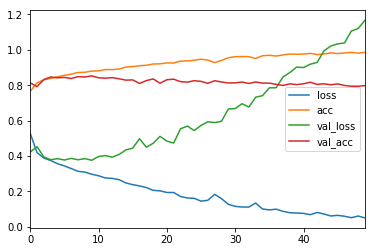

In [15]:
pd.DataFrame(history_cnn.history).plot()

The recall is  0.761
The precision is 0.7777210015329586


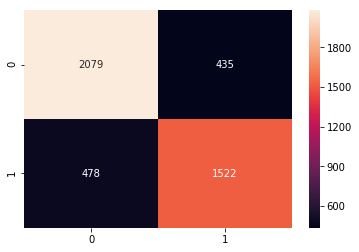

In [16]:
val_pred, val_classes = predict_from_generator(val_generator, cnn_small_bn)


cnf_matrix_val = confusion_matrix(val_classes, val_pred)

fig1 = sns.heatmap(cnf_matrix_val, annot=True, fmt="d")


print("The recall is ", recall_score(val_classes, val_pred))

print("The precision is", precision_score(val_classes, val_pred))

The recall is  0.6951438848920863
The precision is 0.8814139110604333


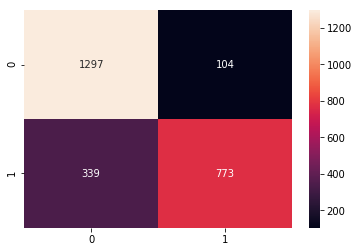

In [17]:
test_pred, test_classes = predict_from_generator(test_generator, cnn_small_bn)


cnf_matrix_test = confusion_matrix(test_classes, test_pred)

fig1 = sns.heatmap(cnf_matrix_test, annot=True, fmt="d")


print("The recall is ", recall_score(test_classes, test_pred))

print("The precision is", precision_score(test_classes, test_pred))

# Improving Baseline (v1)

In [46]:
num_classes = 2
input_shape = (150, 150, 3)


cnn_small_bn_v2 = Sequential([
    
    Conv2D(16, kernel_size = (4,4), input_shape=input_shape, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size = (4,4), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size = (4,4), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(16),
    Dropout(0.5),
    Dense(num_classes, activation='softmax'),
                 ])

cnn_small_bn_v2.summary()

cnn_small_bn_v2.compile("adam", "categorical_crossentropy",
                     metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 147, 147, 16)      784       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 70, 70, 16)        4112      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 35, 35, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 16)        4112      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 4096)             

In [47]:
history_cnn = cnn_small_bn_v2.fit_generator(
    train_generator,
    steps_per_epoch=train_size/batch_size,
    epochs=20,
    verbose=1,
    validation_data=val_generator,
    validation_steps=val_size/ batch_size)


Epoch 1/20
283/282 [==============================] - 30s 106ms/step - loss: 0.4856 - acc: 0.7828 - val_loss: 0.4061 - val_acc: 0.8228
Epoch 2/20
283/282 [==============================] - 29s 102ms/step - loss: 0.4327 - acc: 0.8156 - val_loss: 0.4429 - val_acc: 0.8090
Epoch 3/20
283/282 [==============================] - 29s 102ms/step - loss: 0.3852 - acc: 0.8372 - val_loss: 0.3561 - val_acc: 0.8509
Epoch 4/20
283/282 [==============================] - 29s 103ms/step - loss: 0.3631 - acc: 0.8516 - val_loss: 0.3728 - val_acc: 0.8451
Epoch 5/20
283/282 [==============================] - 30s 106ms/step - loss: 0.3416 - acc: 0.8612 - val_loss: 0.3806 - val_acc: 0.8474
Epoch 6/20
283/282 [==============================] - 29s 103ms/step - loss: 0.3335 - acc: 0.8693 - val_loss: 0.3237 - val_acc: 0.8655
Epoch 7/20
283/282 [==============================] - 29s 104ms/step - loss: 0.3199 - acc: 0.8732 - val_loss: 0.3294 - val_acc: 0.8633
Epoch 8/20
283/282 [==============================] - 2

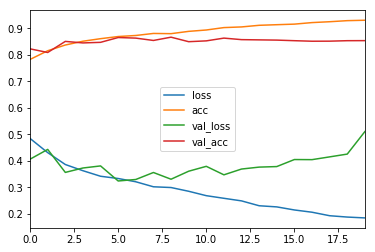

In [48]:
pd.DataFrame(history_cnn.history).plot()

The recall is  0.7745
The precision is 0.8811149032992036


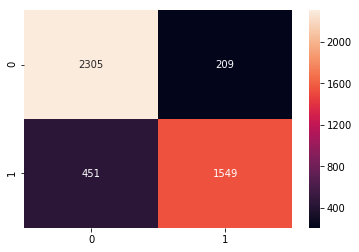

In [49]:

val_pred, val_classes = predict_from_generator(val_generator, cnn_small_bn_v2)


cnf_matrix_val = confusion_matrix(val_classes, val_pred)

fig1 = sns.heatmap(cnf_matrix_val, annot=True, fmt="d")

print("The recall is ", recall_score(val_classes, val_pred))

print("The precision is", precision_score(val_classes, val_pred))

The recall is  0.7526978417266187
The precision is 0.9468325791855203


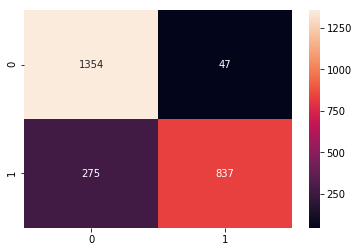

In [50]:
test_pred, test_classes = predict_from_generator(test_generator, cnn_small_bn_v2)


cnf_matrix_test = confusion_matrix(test_classes, test_pred)

fig1 = sns.heatmap(cnf_matrix_test, annot=True, fmt="d")


print("The recall is ", recall_score(test_classes, test_pred))

print("The precision is", precision_score(test_classes, test_pred))

## Improving Baseline (v2)

In [51]:
num_classes = 2
input_shape = (150, 150, 3)


cnn_small_bn_v3 = Sequential([
    
    Conv2D(16, kernel_size = (4,4), input_shape=input_shape, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size = (4,4), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size = (4,4), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size = (4,4), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(16),
    Dropout(0.5),
    Dense(num_classes, activation='softmax'),
                 ])

cnn_small_bn_v3.summary()

cnn_small_bn_v3.compile("adam", "categorical_crossentropy",
                     metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 147, 147, 16)      784       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 70, 70, 16)        4112      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 35, 35, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 16)        4112      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 13, 13, 16)       

In [52]:
history_cnn = cnn_small_bn_v3.fit_generator(
    train_generator,
    steps_per_epoch=train_size/batch_size,
    epochs=20,
    verbose=1,
    validation_data=val_generator,
    validation_steps=val_size/ batch_size)


Epoch 1/20
283/282 [==============================] - 32s 112ms/step - loss: 0.4754 - acc: 0.7885 - val_loss: 0.3981 - val_acc: 0.8292
Epoch 2/20
283/282 [==============================] - 30s 106ms/step - loss: 0.4056 - acc: 0.8269 - val_loss: 0.3821 - val_acc: 0.8451
Epoch 3/20
283/282 [==============================] - 30s 105ms/step - loss: 0.3770 - acc: 0.8453 - val_loss: 0.3354 - val_acc: 0.8622
Epoch 4/20
283/282 [==============================] - 30s 104ms/step - loss: 0.3674 - acc: 0.8509 - val_loss: 0.3225 - val_acc: 0.8658
Epoch 5/20
283/282 [==============================] - 30s 105ms/step - loss: 0.3417 - acc: 0.8620 - val_loss: 0.3177 - val_acc: 0.8708
Epoch 6/20
283/282 [==============================] - 29s 104ms/step - loss: 0.3343 - acc: 0.8665 - val_loss: 0.3070 - val_acc: 0.8726
Epoch 7/20
283/282 [==============================] - 29s 103ms/step - loss: 0.3271 - acc: 0.8694 - val_loss: 0.3004 - val_acc: 0.8748
Epoch 8/20
283/282 [==============================] - 2

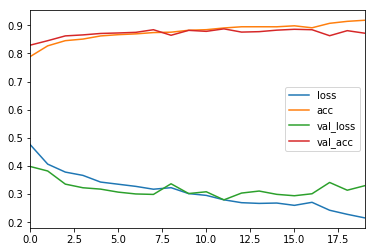

In [54]:
pd.DataFrame(history_cnn.history).plot()

The recall is  0.867
The precision is 0.8470933072789448


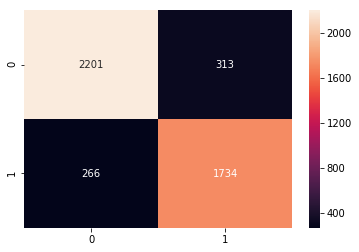

In [55]:

val_pred, val_classes = predict_from_generator(val_generator, cnn_small_bn_v3)


cnf_matrix_val = confusion_matrix(val_classes, val_pred)

fig1 = sns.heatmap(cnf_matrix_val, annot=True, fmt="d")

print("The recall is ", recall_score(val_classes, val_pred))

print("The precision is", precision_score(val_classes, val_pred))

The recall is  0.8534172661870504
The precision is 0.9072657743785851


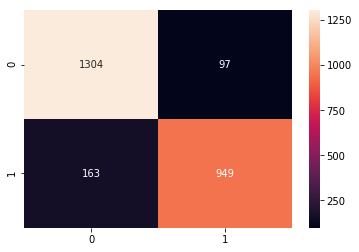

In [56]:
test_pred, test_classes = predict_from_generator(test_generator, cnn_small_bn_v3)


cnf_matrix_test = confusion_matrix(test_classes, test_pred)

fig1 = sns.heatmap(cnf_matrix_test, annot=True, fmt="d")


print("The recall is ", recall_score(test_classes, test_pred))

print("The precision is", precision_score(test_classes, test_pred))

In [0]:
# datagen = ImageDataGenerator(
# rotation_range=40,
# width_shift_range=0.2,
# height_shift_range=0.2,
# shear_range=0.2,
# zoom_range=0.2,
# horizontal_flip=True)